# Проект 5 (предварительная модель).<br />Модель кредитного скоринга<br />на основе логистической регресии

## 0. Импорт библиотек и настройки

In [1]:
from pandas import Series
import pandas as pd
import numpy as np

# ====================

import matplotlib.pyplot as plt
import seaborn as sns

# ====================

from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc, roc_auc_score, roc_curve

In [2]:
# Настройка matplotlib для IPython
%matplotlib inline

# Отображение максмально возможного количества колонок из DataFrame в Jupyter Notebook
pd.set_option('display.max_columns', None)

## 1. Загрузка сырых данных,<br />преобразование данных<br />и их предварительная обработка

### 1.1 Загрузка сырых данных

In [3]:
raw_data = pd.read_csv("../00-data/train.csv")

In [4]:
raw_data.sample(5)

client_id education sex  age car car_type  decline_app_cnt  good_work  \
29558      56099       UGR   F   23   N        N                0          0   
13789       8501       UGR   M   27   N        N                0          0   
20724         63       SCH   M   30   Y        N                0          1   
21108      53742       GRD   F   54   N        N                0          0   
15875      20494       SCH   M   57   Y        Y                1          0   

       bki_request_cnt  home_address  work_address  income foreign_passport  \
29558                0             2             3   80000                N   
13789                2             2             3   30000                N   
20724                2             2             3   45000                Y   
21108                0             2             3   60000                N   
15875                2             2             3   55000                N   

       default  
29558        1  
13789        0  
20724        1  
21108        0  
15875        0

### 1.2 Первичное описание сырых данных

#### 1.2.1 Колонки и их типы

In [5]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73799 entries, 0 to 73798
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   client_id         73799 non-null  int64 
 1   education         73492 non-null  object
 2   sex               73799 non-null  object
 3   age               73799 non-null  int64 
 4   car               73799 non-null  object
 5   car_type          73799 non-null  object
 6   decline_app_cnt   73799 non-null  int64 
 7   good_work         73799 non-null  int64 
 8   bki_request_cnt   73799 non-null  int64 
 9   home_address      73799 non-null  int64 
 10  work_address      73799 non-null  int64 
 11  income            73799 non-null  int64 
 12  foreign_passport  73799 non-null  object
 13  default           73799 non-null  int64 
dtypes: int64(9), object(5)
memory usage: 7.9+ MB


#### 1.2.2 Наличие и количество пропусков в сырых данных

In [6]:
gaps_raw_data = raw_data.isna().sum()
gaps_raw_data

client_id             0
education           307
sex                   0
age                   0
car                   0
car_type              0
decline_app_cnt       0
good_work             0
bki_request_cnt       0
home_address          0
work_address          0
income                0
foreign_passport      0
default               0
dtype: int64

In [7]:
number_records = raw_data.shape[0]
gaps_education = gaps_raw_data.loc['education']
print(f"Число записей в мсходной выборке: {number_records}.")
print(f"Число пропусков в колонке \"education\": {gaps_education}.")
print(f"Доля пропусков в колонке \"education\": {np.round(100 * (gaps_education / number_records), 3)} %")

Число записей в мсходной выборке: 73799.
Число пропусков в колонке "education": 307.
Доля пропусков в колонке "education": 0.416 %


Видно, что пропуски есть **только** в колонке `education` (уровень образования заёмщика).<br />
При этом доля пропусков в этой колонке по отношени к
размеру выборки составляет $\approx 0.4\,\%$.

**Таким образом**, можно предварительно сделать вывод,
что эти пропуски можно удалить,<br />
учитывая всеобщее массовое образование сегодня, либо ввести новое дефолтное значение,<br />
если данных об образовании нет.

Ниже, **в секции предобработки данных**, попытаемся сначала заменить пропуски<br />
в колонке `education` на новое значение этого категориального признака.

### 1.3 Предобработка данных<br />с явным выделением типов признаков

Для предобработки будем использовать средства библиотеки `sklearn`.

In [8]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler

class BasicFeatureTransformer:
    """A simple feature transformer class made for convenience."""
    mappings_binary_features = dict()
    mappings_categorical_features = dict()

    # A primitive constrtuctor
    def __init__(self):
        return


    def move_columns_after_given_one(self, data: pd.DataFrame,
        column_names: list, given_column_name: str):
        """
        Inplace mover of a list of columns to the place
        after the given column the order they are in
        the column name list.

        Parameters
        ---------
        data : pd.DataFrame
            original data with binary feature columns
        column_names : list
            a list of column names to move in the order
            they are present in this collection
        given_column_name : str
            a column name after which the tagret columns are to be placed

        Returns
        ------
        pd.DataFrame
            the modified original data
        """
        for i, column_name in enumerate(column_names):
            data.insert(
                data.columns.get_loc(given_column_name) + (i + 1),
                column_name, data.pop(column_name)
            )
        return data


    def transform_features_binary(self, data: pd.DataFrame, column_names: list):
        """
        Inplace transformer for binary features

        Parameters
        ---------
        data : pd.DataFrame
            original data with binary feature columns
        column_names : list
            a list of column names which correspond to binary features

        Returns
        ------
        pd.DataFrame
            the modified original data
        """
        for column_name in column_names:
            label_encoder = LabelEncoder()
            data[column_name] = label_encoder.fit_transform(data[column_name])

            # Record the information about mappings of the new numerical binary values.
            self.mappings_binary_features[column_name] = \
                {
                    "feature_names": dict(enumerate(label_encoder.classes_)),
                    "encoder": label_encoder
                }

        return data


    def transform_features_categorical(self, data: pd.DataFrame, column_names: list):
        """
        Inplace transformer for categorical features

        Parameters
        ---------
        data : pd.DataFrame
            original data with binary feature columns
        column_names : list
            a list of column names which correspond to categorical features

        Returns
        ------
        pd.DataFrame
            the modified original data
        """
        for column_name in column_names:
            onehot_encoder = OneHotEncoder(sparse = False)
            transform_result = onehot_encoder.fit_transform(
                data[column_name].to_numpy().reshape(-1, 1)
            )
            new_dummy_column_names = onehot_encoder.get_feature_names([column_name])

            onehot_data = pd.DataFrame(transform_result, columns=new_dummy_column_names)

            data = pd.concat([data, onehot_data], axis=1)
            data.drop([column_name], axis=1, inplace=True)
            
            # Record the information about mappings of the new numerical binary values.
            self.mappings_categorical_features[column_name] = \
                {
                    "feature_names": new_dummy_column_names,
                    "parameters": onehot_encoder.get_params(deep=True),
                    "encoder": onehot_encoder
                }

        return data

In [9]:
feature_transformer = BasicFeatureTransformer()

#### 1.3.1 Определение типов переменных (признаков)

##### 1.3.1.1 Числовые признаки

|Название колонки|Описание признака|
|:-------------|:---------------|
|age|Возраст заёмщика.|
|decline_app_cnt|Количество отказанных прошлых заявок на кредит.|
|bki_request_cnt|Количество запросов в базу БКИ.|
|income|Доход заёмщика.|

In [10]:
# Колонки числовых признаков
numerical_columns = ["age", "decline_app_cnt", "bki_request_cnt", "income"]

*Важно:* всё же исменим порядок колонок в списке `numerical_columns`<br />
на более удобный для субъективного восприятия по важности.

Позже поместим колонки числовый признаков первыми в датасете<br />
в указанном в списке порядке.

In [11]:
numerical_columns = ["income", "age", "decline_app_cnt", "bki_request_cnt"]

##### 1.3.1.2 Бинарные признаки

|Название колонки|Описание признака|
|:-------------|:---------------|
|sex|Пол заёмщика.|
|car|Бинарный флаг наличия автомобиля.|
|car_type|Бинарный флаг наличия автомобиля-иномарки.|
|foreign_passport|Флаг наличия загранпаспорта.|
|good_work|Флаг наличия «хорошей» работы.|

In [12]:
# Колонки бинарных признаков
binary_columns = ["good_work", "car", "car_type", "foreign_passport", "sex"]

##### 1.3.1.3 Категориальные признаки

|Название колонки|Описание признака|
|:-------------|:---------------|
|education|Уровень образования заёмщика.|
|home_address|Категоризатор домашнего адреса.|
|work_address|Категоризатор рабочего адреса.|

In [13]:
# Колонки категориальных признаков
categorical_columns = ["education", "home_address", "work_address"]

#### 1.3.2 Преобразование признаков к виду,<br />пригодному для дальнейшей предобработки и<br />для выбранной математической модели

##### 1.3.2.1 Числовые признаки

У числовых признаков нет пропусков и они, в целом,<br />
не нуждаются в первичной предварительной обработке,<br />
преобразовывающей их в числовую форму.
Изменим только порядок колонок.

In [14]:
pre_data = feature_transformer.move_columns_after_given_one(
    raw_data, numerical_columns, "client_id"
)
pre_data.sample(3)

client_id  income  age  decline_app_cnt  bki_request_cnt education sex  \
23866      15139    7800   57                0                2       SCH   F   
52058      95570   30000   22                0                4       SCH   F   
58298      24112   30000   46                0                1       GRD   F   

      car car_type  good_work  home_address  work_address foreign_passport  \
23866   N        N          0             1             2                N   
52058   N        N          0             1             2                N   
58298   Y        Y          0             2             3                N   

       default  
23866        0  
52058        0  
58298        0

##### 1.3.2.2 Бинарные признаки
Преобразуем все бинарные признаки c помощью `BasicFeatureTransformer` и<br />
поместим их после числовых признаков.

Колонку `sex` заранее переименуем в `sex_male` (male - 1, female - 0).

In [15]:
pre_data.rename(columns={"sex": "sex_male"}, inplace=True)
binary_columns = \
    list(map(lambda name: "sex_male" if name == "sex" else name, binary_columns))

pre_data = feature_transformer.transform_features_binary(pre_data, binary_columns)
feature_transformer.mappings_binary_features

{'good_work': {'feature_names': {0: 0, 1: 1}, 'encoder': LabelEncoder()},
 'car': {'feature_names': {0: 'N', 1: 'Y'}, 'encoder': LabelEncoder()},
 'car_type': {'feature_names': {0: 'N', 1: 'Y'}, 'encoder': LabelEncoder()},
 'foreign_passport': {'feature_names': {0: 'N', 1: 'Y'},
  'encoder': LabelEncoder()},
 'sex_male': {'feature_names': {0: 'F', 1: 'M'}, 'encoder': LabelEncoder()}}

In [16]:
pre_data = feature_transformer.move_columns_after_given_one(
    pre_data, binary_columns, numerical_columns[-1]
)
pre_data.sample(3)

client_id  income  age  decline_app_cnt  bki_request_cnt  good_work  \
68071      82896   80000   42                0                1          0   
46956     105311    6400   51                2                6          0   
17382      90771   25000   24                0                2          0   

       car  car_type  foreign_passport  sex_male education  home_address  \
68071    1         0                 0         1       UGR             1   
46956    0         0                 0         0       SCH             2   
17382    0         0                 0         1       GRD             1   

       work_address  default  
68071             3        0  
46956             3        0  
17382             2        0

##### 1.3.2.3 Категориальные признаки

В колонке education найденные пропуски явно пометим новым строковым значением "NULL".
Сначала сгенерируем новый отчёт в `pandas_profiling` на текущих предобработанных данных.

In [17]:
pre_data["education"] = pre_data["education"].fillna("NULL")
pre_data.sample(3)

client_id  income  age  decline_app_cnt  bki_request_cnt  good_work  \
73766      18432   20000   37                0                2          0   
64391      26812   50000   61                0                1          0   
23457       2706    7000   59                0                1          0   

       car  car_type  foreign_passport  sex_male education  home_address  \
73766    1         0                 0         0       SCH             1   
64391    0         0                 0         0       GRD             2   
23457    1         0                 0         1       SCH             1   

       work_address  default  
73766             3        0  
64391             3        0  
23457             1        0

### 1.4 Отчёт Pandas Profiling по предобработанным данным без dummy признаков
<a id='pre_data_profiling_report'></a>

In [18]:
import pandas_profiling as pdp

pre_data_profile = pdp.ProfileReport(
    pre_data,
    title="Sample Financial Scoring Data Profiling Report"
)
pre_data_profile.to_file("02-EDA-Dmitry_Vlasov-Project_5-Solution-Finantial-Scoring.html")
pre_data_profile.to_notebook_iframe()

Export report to file: 100%|██████████| 1/1 [00:00<00:00, 129.17it/s]


## 2. Предварительный анализ признаков,<br />первичный feature engineering,<br />работа с выбросами,<br />простой анализ корреляций.

### 2.1 Анализ целевой переменной

<AxesSubplot:>

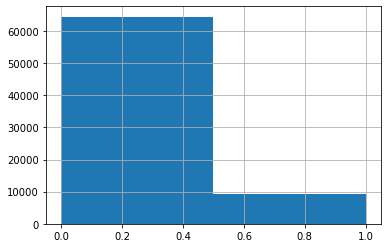

In [19]:
pre_data.default.hist(bins=2)

In [20]:
sample_size = pre_data.shape[0]
class_positive = pre_data.default[pre_data.default == 1].count()
class_negative = pre_data.default[pre_data.default == 0].count()
print(f"Positive class size: {class_positive}, {(class_positive / sample_size) * 100} %")
print(f"Negative class size: {class_negative}, {(class_negative / sample_size) * 100} %")

Positive class size: 9372, 12.699359069906096 %
Negative class size: 64427, 87.3006409300939 %


Видим, что имеется **дисбалланс выборки** по классам целевой переменной.
Попытаемся это решить позже при обучении логистической регрессии, введя веса для этих двух классов.

### 2.2 Анализ числовых переменных

Из отчёта в секции [1.4](#pre_data_profiling_report) видно, что числовые переменые из
`numerical_columns` имеют распределения сильно смещённые вправо и похожи на логнормальные распределения. В секции 4 при создании новых признаков к этим переменным будет применён натуральный логарифм силу того, что такая операция может приблизить распределения к нормальным (применение натурального логарифма к логнормальному распределению даёт нормальное распределение).

In [21]:
numerical_columns

['income', 'age', 'decline_app_cnt', 'bki_request_cnt']

In [22]:
pre_data[numerical_columns].describe()

income           age  decline_app_cnt  bki_request_cnt
count    73799.000000  73799.000000     73799.000000     73799.000000
mean     41099.775417     39.280641         0.275749         2.000339
std      46166.322400     11.520378         0.804272         2.252073
min       1000.000000     21.000000         0.000000         0.000000
25%      20000.000000     30.000000         0.000000         0.000000
50%      30000.000000     37.000000         0.000000         1.000000
75%      48000.000000     48.000000         0.000000         3.000000
max    1000000.000000     72.000000        33.000000        53.000000

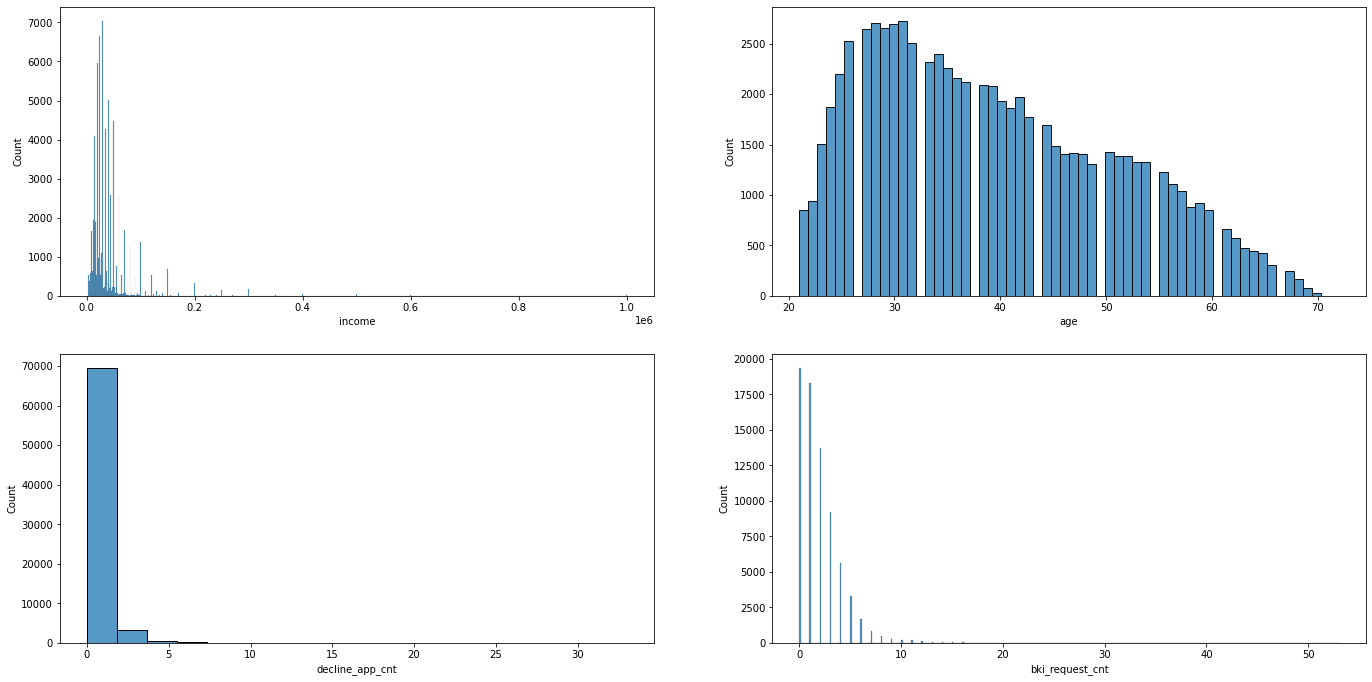

In [23]:
figure_rows = 2
figure_columns = 2
figure, axes = plt.subplots(nrows=figure_rows, ncols=figure_columns)
figure.set_size_inches(23.4, 11.7)
for i in range(0, figure_rows):
    for j in range(0, figure_columns):
        c_index = i * figure_rows + j
        column_name = numerical_columns[c_index]
        sns.histplot(x=column_name, data=pre_data[[column_name]], ax=axes[i, j])

Визуализация применения натурального логарифма:

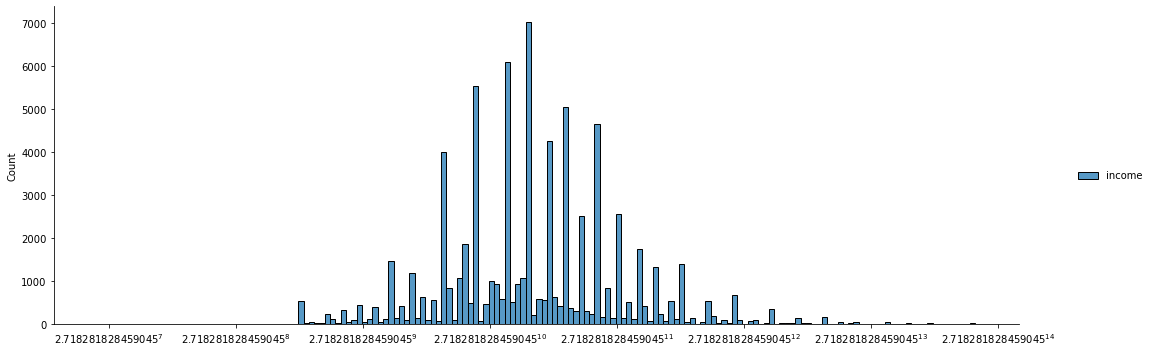

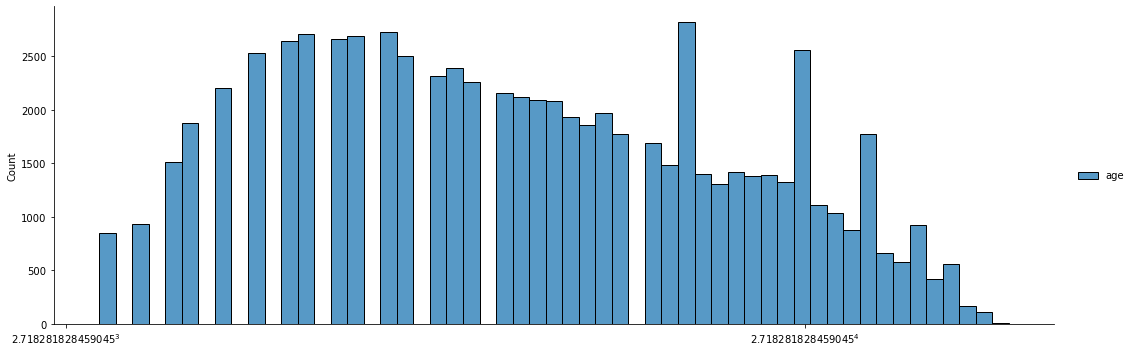

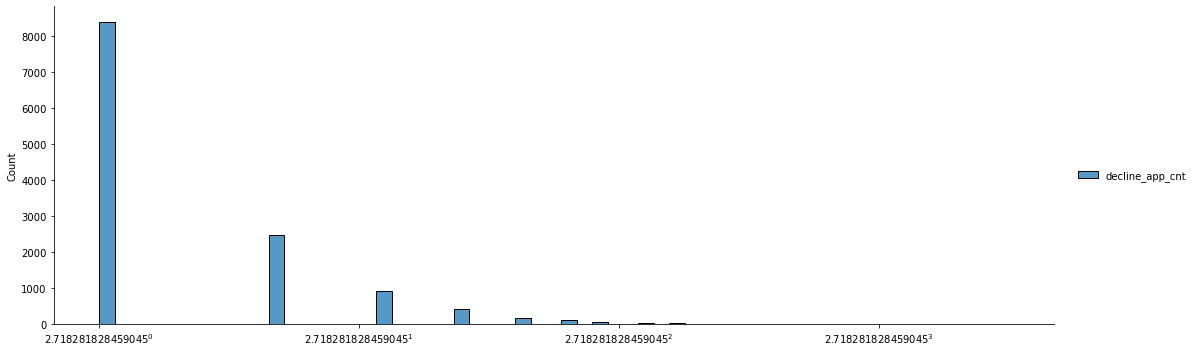

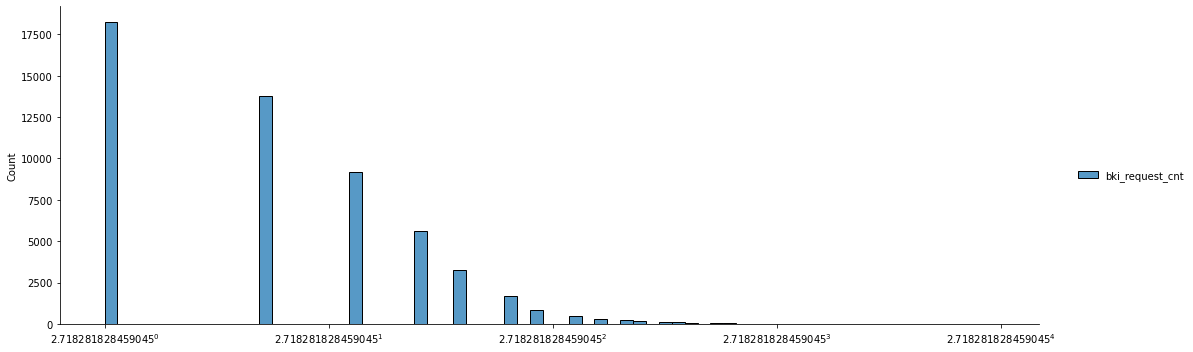

In [24]:
figure_rows = 2
figure_columns = 2
# figure, axes = plt.subplots(nrows=figure_rows, ncols=figure_columns)
# figure.set_size_inches(23.4, 11.7)
for i in range(0, figure_rows):
    for j in range(0, figure_columns):
        c_index = i * figure_rows + j
        column_name = numerical_columns[c_index]
        c_data = pre_data[[column_name]]
        c_data = c_data[c_data > 0]
        sns.displot(
            c_data[[column_name]], log_scale=np.e,
            # kde=False, rug=False,
            aspect=3.0
        )

Из логарифмированных распределений видно, что стоит логафифмировать только переменные `income` и `age`, а переменные `decline_app_cnt` и `bki_request_cnt` лучше не логарифмировать. В любом случае `decline_app_cnt` и `bki_request_cnt` можно подвергнуть стандартизации.

#### 2.2.1 income - default

In [25]:
print(f"Средний доход людей, у которых был дефолт: {pre_data[pre_data.default == 1].income.mean()} у.е.")
print(f"Медианный доход людей, у которых был дефолт: {pre_data[pre_data.default == 1].income.median()} у.е.")
print("----------")
print(f"Средний доход людей, у которых не было дефолта: {pre_data[pre_data.default == 0].income.mean()} у.е.")
print(f"Медианный доход людей, у которых не было дефолта: {pre_data[pre_data.default == 0].income.median()} у.е.")

Средний доход людей, у которых был дефолт: 36288.1133162612 у.е.
Медианный доход людей, у которых был дефолт: 28000.0 у.е.
----------
Средний доход людей, у которых не было дефолта: 41799.713287907245 у.е.
Медианный доход людей, у которых не было дефолта: 30000.0 у.е.


Text(0, 0.5, 'Frequency of Defaults')

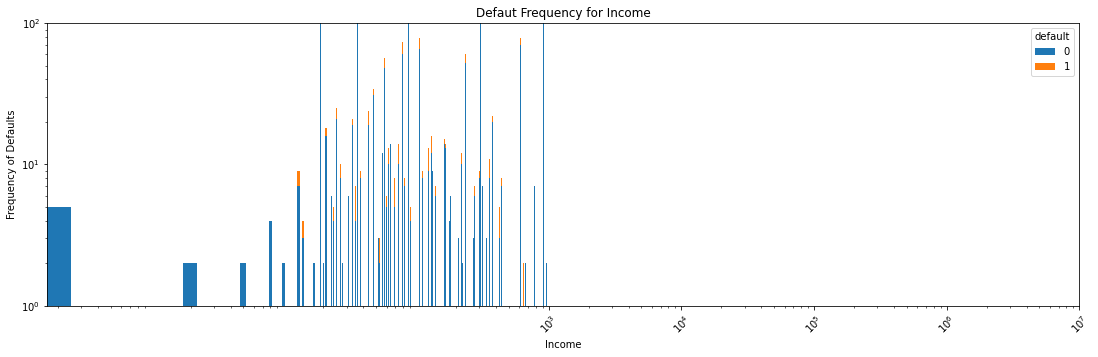

In [26]:
income_min = pre_data.income.min()
income_max = pre_data.income.max()
log10_income_min = int(np.round(np.log10(income_min)))
log10_income_max = int(np.round(np.log10(income_max)))
fig_data = pre_data[pre_data.income >= income_min]
pd.crosstab(fig_data.income, fig_data.default).plot(
    kind='bar', figsize=(18.5, 5.2),
    logx=True,
    xticks=np.logspace(
        log10_income_min,
        log10_income_max + 1,
        (log10_income_max - log10_income_min) + 2
    ),
    rot=45,
    ylim=(0, 100), logy=True,
    stacked=True
)
plt.title('Defaut Frequency for Income')
plt.xlabel('Income')
plt.ylabel('Frequency of Defaults')

In [27]:
pre_data.income.value_counts(bins=100)[:20]

(20980.0, 30970.0]      18678
(10990.0, 20980.0]      17153
(30970.0, 40960.0]      11698
(40960.0, 50950.0]       8194
(0.999, 10990.0]         4338
(50950.0, 60940.0]       3884
(60940.0, 70930.0]       2490
(70930.0, 80920.0]       1828
(90910.0, 100900.0]      1559
(80920.0, 90910.0]        841
(140860.0, 150850.0]      705
(110890.0, 120880.0]      589
(190810.0, 200800.0]      346
(100900.0, 110890.0]      189
(120880.0, 130870.0]      182
(290710.0, 300700.0]      170
(240760.0, 250750.0]      148
(130870.0, 140860.0]      112
(150850.0, 160840.0]       98
(170830.0, 180820.0]       97
Name: income, dtype: int64

In [28]:
pre_data.income.value_counts(bins=50)[:20]

(20980.0, 40960.0]       30376
(0.999, 20980.0]         21491
(40960.0, 60940.0]       12078
(60940.0, 80920.0]        4318
(80920.0, 100900.0]       2400
(140860.0, 160840.0]       803
(100900.0, 120880.0]       778
(180820.0, 200800.0]       373
(120880.0, 140860.0]       294
(160840.0, 180820.0]       175
(280720.0, 300700.0]       173
(240760.0, 260740.0]       160
(480520.0, 500500.0]        54
(380620.0, 400600.0]        46
(200800.0, 220780.0]        44
(220780.0, 240760.0]        40
(340660.0, 360640.0]        37
(260740.0, 280720.0]        28
(580420.0, 600400.0]        20
(980020.0, 1000000.0]       16
Name: income, dtype: int64

Видно, что большинство заёмщиков, берущих кредиты, находятся в условных сегментах со средними и низкими доходами. Это может быть сомнительно, но возможно, что это и есть основная целевая клиентура банка. Однако у нас нет информации об объёмах кредитования
в зависимости от доходов человека, поэтому просто так исключать сегмент с высокими доходами не стоит.

#### 2.2.2 age - default

In [29]:
print(f"Средний возраст людей, у которых был дефолт: {pre_data[pre_data.default == 1].age.mean()} лет.")
print(f"Медианный возраст людей, у которых был дефолт: {pre_data[pre_data.default == 1].age.median()} лет.")
print("----------")
print(f"Средний возраст людей, у которых не было дефолта: {pre_data[pre_data.default == 0].age.mean()} лет.")
print(f"Медианный возраст людей, у которых не было дефолта: {pre_data[pre_data.default == 0].age.median()} лет.")

Средний возраст людей, у которых был дефолт: 38.52539479300043 лет.
Медианный возраст людей, у которых был дефолт: 36.0 лет.
----------
Средний возраст людей, у которых не было дефолта: 39.3905039812501 лет.
Медианный возраст людей, у которых не было дефолта: 38.0 лет.


Text(0, 0.5, 'Frequency of Defaults')

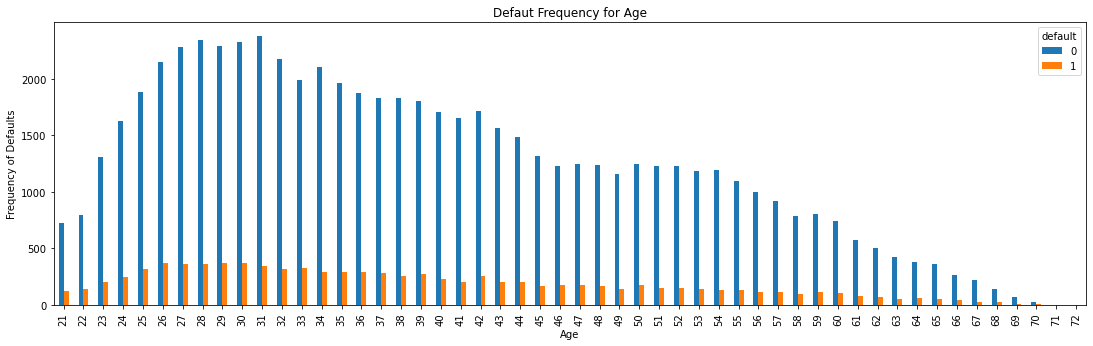

In [30]:
pd.crosstab(pre_data.age, pre_data.default).plot(
    kind='bar', figsize=(18.5, 5.2)
)
plt.title('Defaut Frequency for Age')
plt.xlabel('Age')
plt.ylabel('Frequency of Defaults')

Text(0, 0.5, 'Frequency of Defaults')

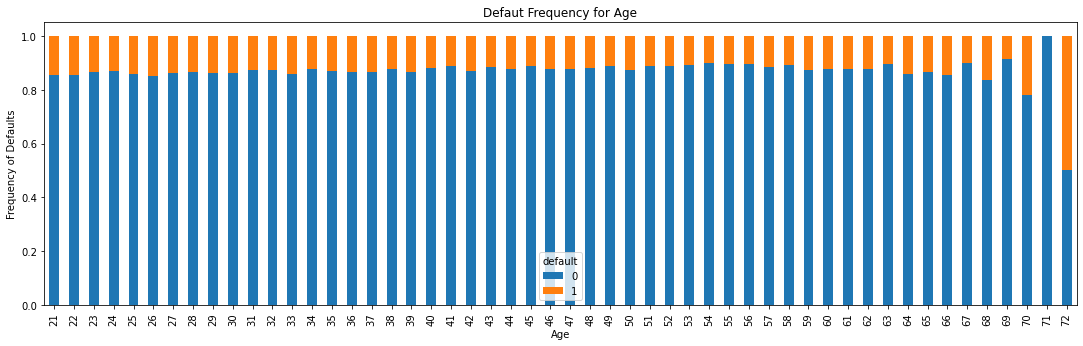

In [31]:
cross_table = pd.crosstab(pre_data.age, pre_data.default)
cross_table = cross_table.div(cross_table.sum(1).astype(float), axis=0)
cross_table.plot(
    kind='bar', stacked=True, figsize=(18.5, 5.2)
)
plt.title('Defaut Frequency for Age')
plt.xlabel('Age')
plt.ylabel('Frequency of Defaults')

Обычно дефолт имеет место у более молодых людей. Но в целом заёмщики вообще емеют более молодой возраст. При этом есть малая вероятность, что у **некоторых** совсем пожилых людей число дефолтов и успешных погашениий примерно одинаково на этой выборке, однако это скорее всего выброс.

#### 2.2.3 decline_app_cnt - default

In [32]:
print(f"Среднее число отказов у людей, у которых был дефолт: {pre_data[pre_data.default == 1].decline_app_cnt.mean()}.")
print(f"Медианное число отказов у людей, у которых был дефолт: {pre_data[pre_data.default == 1].decline_app_cnt.median()}.")
print("----------")
print(f"Среднее число отказов у людей, у которых не было дефолта: {pre_data[pre_data.default == 0].decline_app_cnt.mean()}.")
print(f"Медианное число отказов у людей, у которых не было дефолта: {pre_data[pre_data.default == 0].decline_app_cnt.median()}.")

Среднее число отказов у людей, у которых был дефолт: 0.5154716175842936.
Медианное число отказов у людей, у которых был дефолт: 0.0.
----------
Среднее число отказов у людей, у которых не было дефолта: 0.2408772719512006.
Медианное число отказов у людей, у которых не было дефолта: 0.0.


Видно, что медиана не показывает различий. В среднем число отказов у людей с дефолтами выше.

Text(0, 0.5, 'Frequency of Defaults')

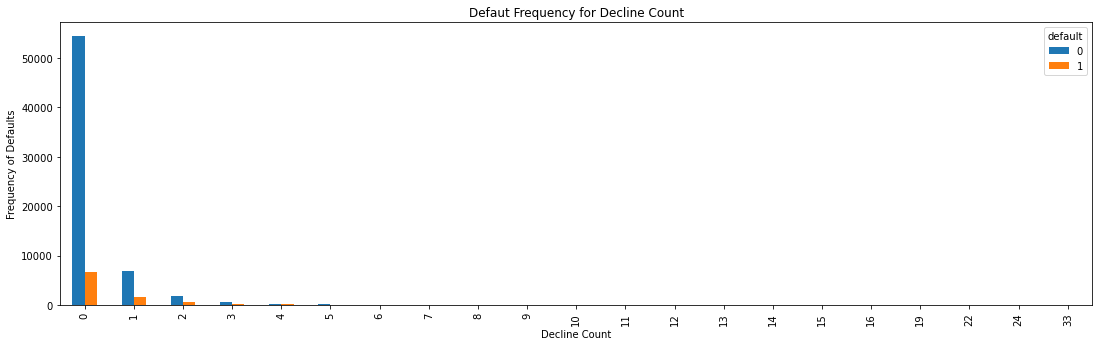

In [33]:
pd.crosstab(pre_data.decline_app_cnt, pre_data.default).plot(
    kind='bar', figsize=(18.5, 5.2)
)
plt.title('Defaut Frequency for Decline Count')
plt.xlabel('Decline Count')
plt.ylabel('Frequency of Defaults')

Text(0, 0.5, 'Frequency of Defaults')

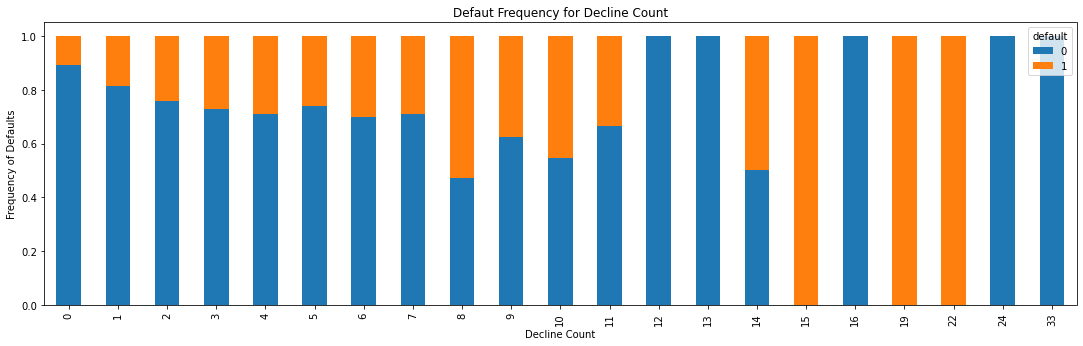

In [34]:
cross_table = pd.crosstab(pre_data.decline_app_cnt, pre_data.default)
cross_table = cross_table.div(cross_table.sum(1).astype(float), axis=0)
cross_table.plot(
    kind='bar', stacked=True, figsize=(18.5, 5.2)
)
plt.title('Defaut Frequency for Decline Count')
plt.xlabel('Decline Count')
plt.ylabel('Frequency of Defaults')

Чем больше дефолтов, тем больше вероятность отказа.

#### 2.2.4 bki_request_cnt - default

In [35]:
print(f"Среднее число запросов в БКИ у людей, у которых был дефолт: {pre_data[pre_data.default == 1].bki_request_cnt.mean()}.")
print(f"Медианное число запросов в БКИ у людей, у которых был дефолт: {pre_data[pre_data.default == 1].bki_request_cnt.median()}.")
print("----------")
print(f"Среднее число запросов в БКИ у людей, у которых не было дефолта: {pre_data[pre_data.default == 0].bki_request_cnt.mean()}.")
print(f"Медианное число запросов в БКИ у людей, у которых не было дефолта: {pre_data[pre_data.default == 0].bki_request_cnt.median()}.")

Среднее число запросов в БКИ у людей, у которых был дефолт: 2.4623346137430646.
Медианное число запросов в БКИ у людей, у которых был дефолт: 2.0.
----------
Среднее число запросов в БКИ у людей, у которых не было дефолта: 1.9331336241016965.
Медианное число запросов в БКИ у людей, у которых не было дефолта: 1.0.


У людей с дефолтами число запросов в БКИ больше.

Text(0, 0.5, 'Frequency of Defaults')

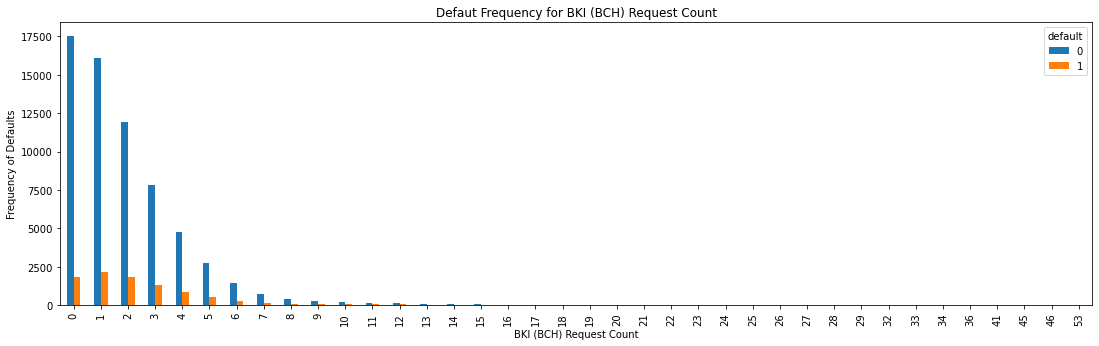

In [36]:
pd.crosstab(pre_data.bki_request_cnt, pre_data.default).plot(
    kind='bar', figsize=(18.5, 5.2)
)
plt.title('Defaut Frequency for BKI (BCH) Request Count')
plt.xlabel('BKI (BCH) Request Count')
plt.ylabel('Frequency of Defaults')

Text(0, 0.5, 'Frequency of Defaults')

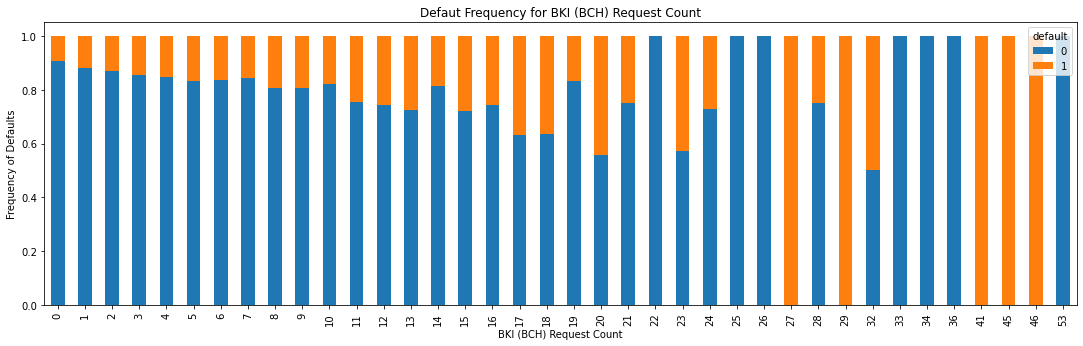

In [37]:
cross_table = pd.crosstab(pre_data.bki_request_cnt, pre_data.default)
cross_table = cross_table.div(cross_table.sum(1).astype(float), axis=0)
cross_table.plot(
    kind='bar', stacked=True, figsize=(18.5, 5.2)
)
plt.title('Defaut Frequency for BKI (BCH) Request Count')
plt.xlabel('BKI (BCH) Request Count')
plt.ylabel('Frequency of Defaults')

Вероятность отказа возрастает с увеличением числа запросов в базу бюро кредитных историй.

#### 2.2.5 Выбросы в числовых переменных

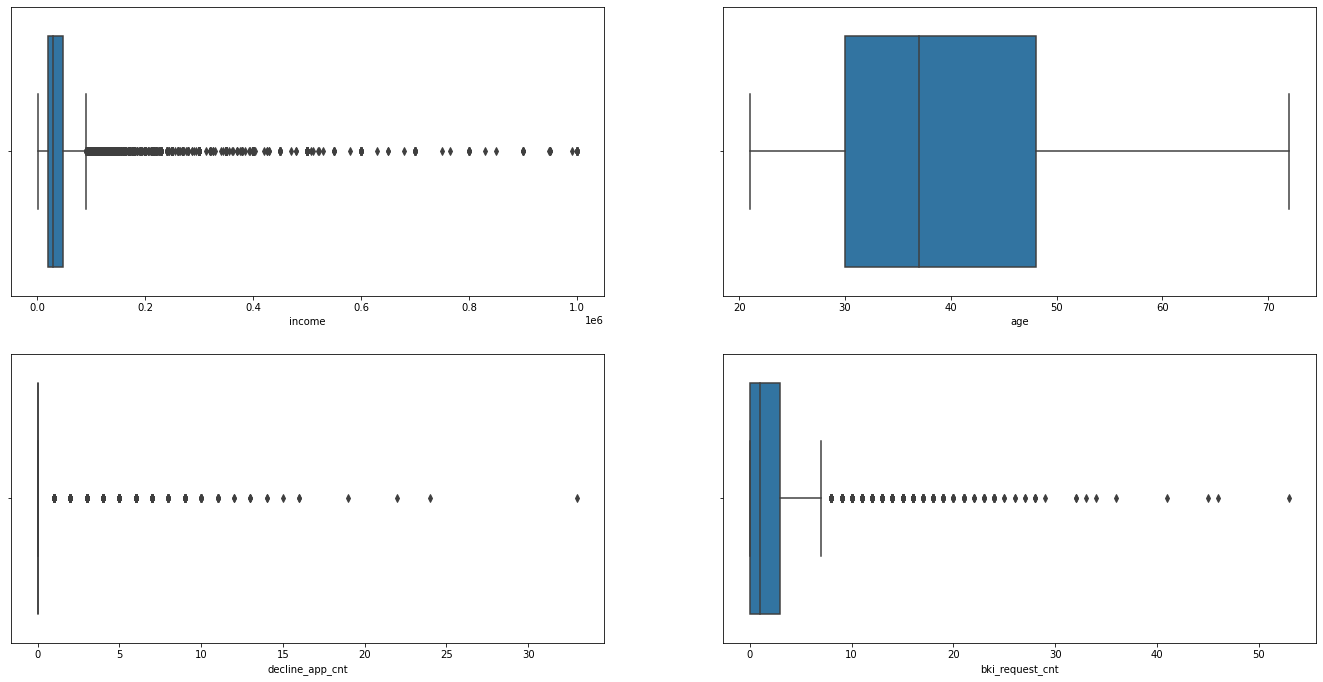

In [38]:
figure_rows = 2
figure_columns = 2
figure, axes = plt.subplots(nrows=figure_rows, ncols=figure_columns)
figure.set_size_inches(23.4, 11.7)
for i in range(0, figure_rows):
    for j in range(0, figure_columns):
        c_index = i * figure_rows + j
        column_name = numerical_columns[c_index]
        sns.boxplot(x=column_name, data=pre_data[[column_name]], ax=axes[i, j])

Видно, что большинство заёмщиков, берущих кредиты, находятся в условных сегментах со средними и низкими доходами. Это может быть сомнительно, но возможно, что это и есть основная целевая клиентура банка. Однако у нас нет информации об объёмах кредитования в зависимости от доходов человека и связанных с этим рисках, поэтому просто так исключать сегмент с высокими доходами не стоит.

У признака Age выбросов нет.

Выбросы в признаках `decline_app_cnt` и `bki_request_cnt` не должны трактоваться как выбросы на данной выборке, поскольку устранив их мы потеряем информацию о случаях,
когда число запросов в БКИ возрастало и также возрастала вероятность отказа по кредиту.

### 2.3 Бинарные признаки

In [39]:
binary_columns

['good_work', 'car', 'car_type', 'foreign_passport', 'sex_male']

In [40]:
pre_data[binary_columns].describe()

good_work           car      car_type  foreign_passport  \
count  73799.000000  73799.000000  73799.000000      73799.000000   
mean       0.164894      0.324760      0.189813          0.149948   
std        0.371087      0.468288      0.392156          0.357023   
min        0.000000      0.000000      0.000000          0.000000   
25%        0.000000      0.000000      0.000000          0.000000   
50%        0.000000      0.000000      0.000000          0.000000   
75%        0.000000      1.000000      0.000000          0.000000   
max        1.000000      1.000000      1.000000          1.000000   

           sex_male  
count  73799.000000  
mean       0.436822  
std        0.495996  
min        0.000000  
25%        0.000000  
50%        0.000000  
75%        1.000000  
max        1.000000

Таблица малопоказательна, но средние значения для интервала от 0 до 1 можно грубо трактовать как вероятности.

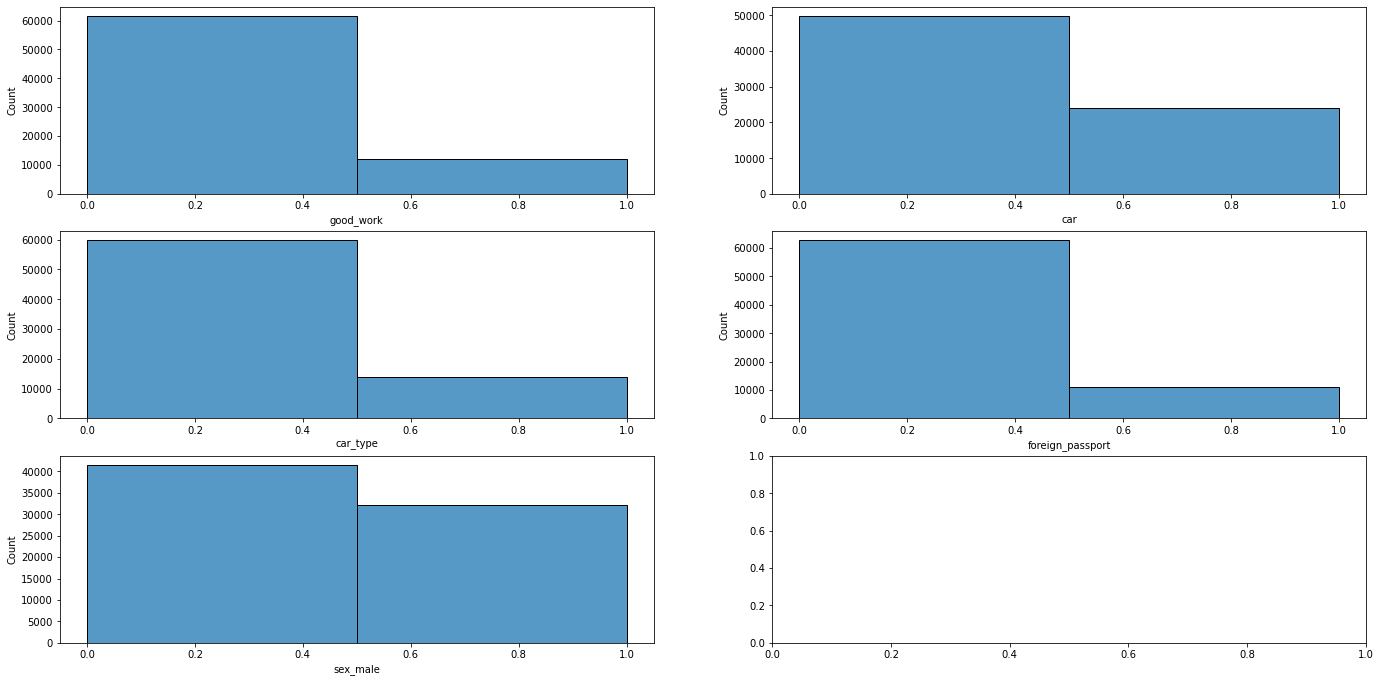

In [41]:
figure_rows = 3
figure_columns = 2
figure, axes = plt.subplots(nrows=figure_rows, ncols=figure_columns)
figure.set_size_inches(23.4, 11.7)
c_index = 0
for i in range(0, figure_rows):
    for j in range(0, figure_columns):
        if c_index > len(binary_columns) - 1:
            break
        column_name = binary_columns[c_index]
        sns.histplot(x=column_name, data=pre_data[[column_name]], ax=axes[i, j], bins=2)
        c_index += 1

Наблюдения:
- у людей мало хороших работ (лучше сказать обобщённо бизнесов, дел);
- людей без машин больше, чем с машинами;
- про число иномарок надо смотреть отдельно;
- у большинства людей нет загранпаспортов;
- женщин больше чем мужчин.

#### 2.3.1 car - default

Text(0, 0.5, 'Frequency of Defaults')

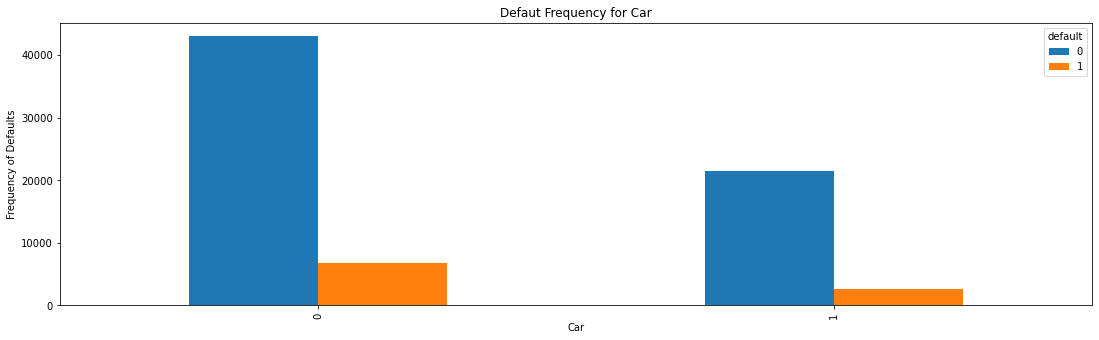

In [42]:
pd.crosstab(pre_data.car, pre_data.default).plot(
    kind='bar', figsize=(18.5, 5.2)
)
plt.title('Defaut Frequency for Car')
plt.xlabel('Car')
plt.ylabel('Frequency of Defaults')

Text(0, 0.5, 'Frequency of Defaults')

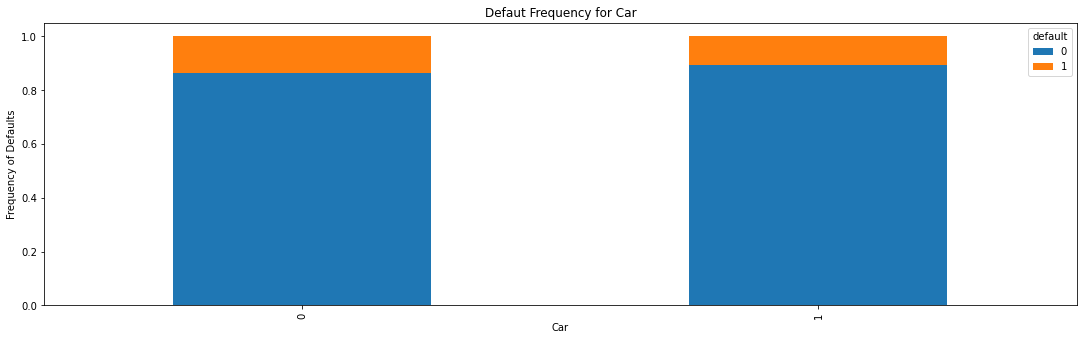

In [43]:
cross_table = pd.crosstab(pre_data.car, pre_data.default)
cross_table = cross_table.div(cross_table.sum(1).astype(float), axis=0)
cross_table.plot(
    kind='bar', stacked=True, figsize=(18.5, 5.2)
)
plt.title('Defaut Frequency for Car')
plt.xlabel('Car')
plt.ylabel('Frequency of Defaults')

У людей без машины риск дефолта чуть выше.

##### 2.3.1.1 car_type - $car = 1$

In [44]:
car_count = pre_data[pre_data.car == 1].car.sum()
foreign_car_count = pre_data[pre_data.car == 1].car_type.sum()
print(car_count)
print(foreign_car_count)
print(100 * foreign_car_count / car_count)

23967
14008
58.44703133475195


Среди владельцев машин $\approx 60\,\%$ это владельцы иномарок.

Text(0, 0.5, 'Frequency of Defaults')

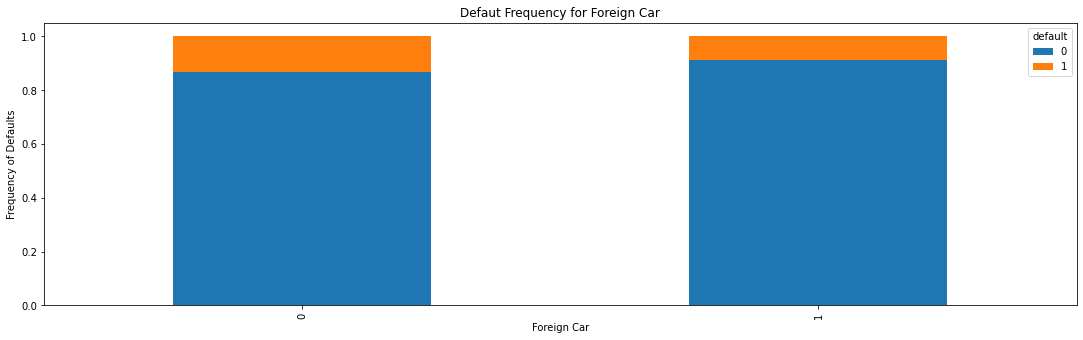

In [45]:
cross_table = pd.crosstab(
    pre_data[pre_data.car == 1].car_type, pre_data[pre_data.car == 1].default)
cross_table = cross_table.div(cross_table.sum(1).astype(float), axis=0)
cross_table.plot(
    kind='bar', stacked=True, figsize=(18.5, 5.2)
)
plt.title('Defaut Frequency for Foreign Car')
plt.xlabel('Foreign Car')
plt.ylabel('Frequency of Defaults')

У владельцев отечественных бюджетных машин риск дефолта выше.

#### 2.3.2 good_work - default

Text(0, 0.5, 'Frequency of Defaults')

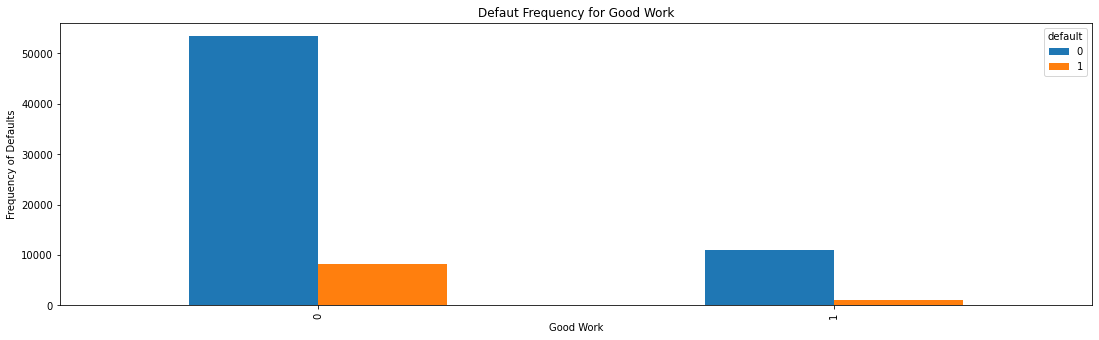

In [46]:
pd.crosstab(pre_data.good_work, pre_data.default).plot(
    kind='bar', figsize=(18.5, 5.2)
)
plt.title('Defaut Frequency for Good Work')
plt.xlabel('Good Work')
plt.ylabel('Frequency of Defaults')

Не очень показательно. Видно только, что те, у кого хорошая работа меньше представлены в выборке, то есть меньше берут кредитов, но не понятно насколько велики кредиты у людей  большими доходами.

Text(0, 0.5, 'Frequency of Defaults')

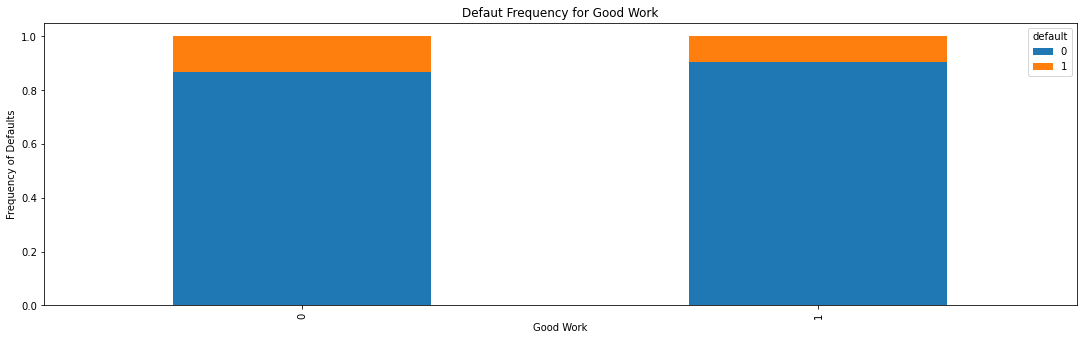

In [47]:
cross_table = pd.crosstab(pre_data.good_work, pre_data.default)
cross_table = cross_table.div(cross_table.sum(1).astype(float), axis=0)
cross_table.plot(
    kind='bar', stacked=True, figsize=(18.5, 5.2)
)
plt.title('Defaut Frequency for Good Work')
plt.xlabel('Good Work')
plt.ylabel('Frequency of Defaults')

Видимо вероятность дефолта у людей с плохой работой чуть выше, если соотносить число людей по качеству работы с числом дефолтов. То есть исключать людей с хорошими работами и высокими зарплатами, как выбросы, нельзя.

#### 2.3.3 foreign_passport - default

Text(0, 0.5, 'Frequency of Defaults')

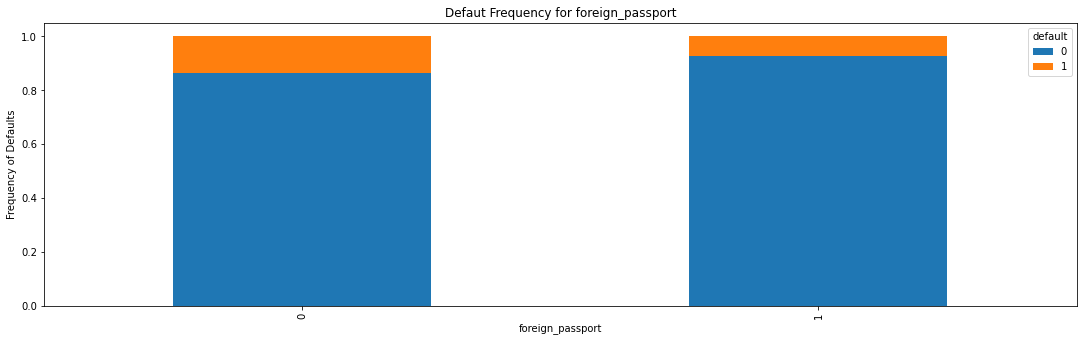

In [48]:
cross_table = pd.crosstab(pre_data.foreign_passport, pre_data.default)
cross_table = cross_table.div(cross_table.sum(1).astype(float), axis=0)
cross_table.plot(
    kind='bar', stacked=True, figsize=(18.5, 5.2)
)
plt.title('Defaut Frequency for foreign_passport')
plt.xlabel('foreign_passport')
plt.ylabel('Frequency of Defaults')

У людей без заграничного паспорта риск дефолта выше.

#### 2.3.4 sex_male - default

Text(0, 0.5, 'Frequency of Defaults')

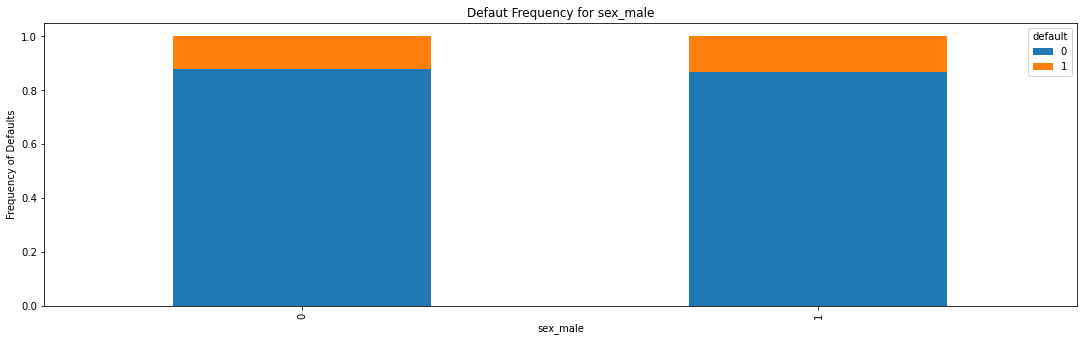

In [49]:
cross_table = pd.crosstab(pre_data.sex_male, pre_data.default)
cross_table = cross_table.div(cross_table.sum(1).astype(float), axis=0)
cross_table.plot(
    kind='bar', stacked=True, figsize=(18.5, 5.2)
)
plt.title('Defaut Frequency for sex_male')
plt.xlabel('sex_male')
plt.ylabel('Frequency of Defaults')

Видимо вероятность дефолта у людей с плохой работой чуть выше, если соотносить число людей по качеству работы с числом дефолтов. То есть исключать людей с хорошими работами и высокими зарплатами, как выбросы, нельзя.

У мужчин риск дефолта выше.

### 2.4 Категориальные признаки

In [50]:
categorical_columns

['education', 'home_address', 'work_address']

#### 2.4.1 education, education - default

<AxesSubplot:>

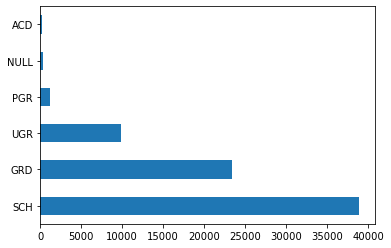

In [51]:
pre_data["education"].value_counts().plot(kind="barh")

Большинство людей имеют обычное школьное образование. И далее по убывающей до академического (исключая NULL).

Text(0, 0.5, 'Frequency of Defaults')

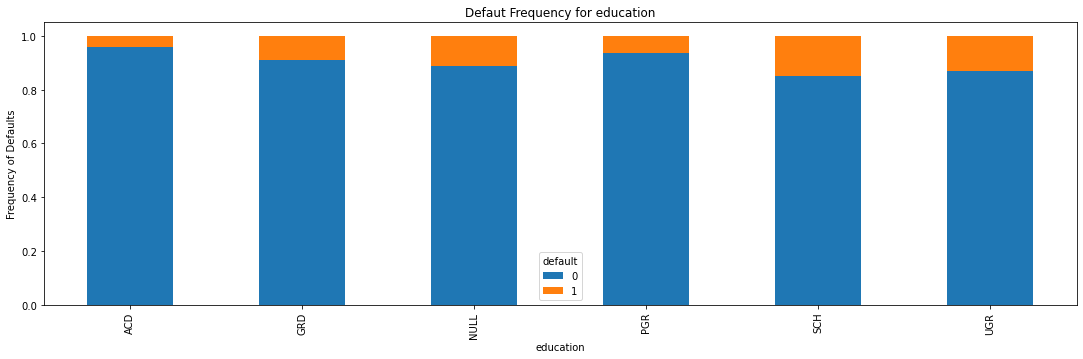

In [52]:
cross_table = pd.crosstab(pre_data.education, pre_data.default)
cross_table = cross_table.div(cross_table.sum(1).astype(float), axis=0)
cross_table.plot(
    kind='bar', stacked=True, figsize=(18.5, 5.2)
)
plt.title('Defaut Frequency for education')
plt.xlabel('education')
plt.ylabel('Frequency of Defaults')

Чаще дефолт происходит у людей:
- со школьным образованием (SCH);
- с дипломами бакалавра (undergraduate - UGR);
- с людьми, которые не указали уровень своего образования (NULL).

Меньше всего дефолтов у людей:
- со степенью доктора (academic - ACD);
- со степенью кандидата (post graduate - PGR);
- со степенью магистра, либо получающего её (graduate - GRD).


Возможно стоит объединить dummy признаки в бинарный признак: хорошее образование и плохое (включая NULL).

#### 2.4.2 home_address - default

Text(0, 0.5, 'Frequency of Defaults')

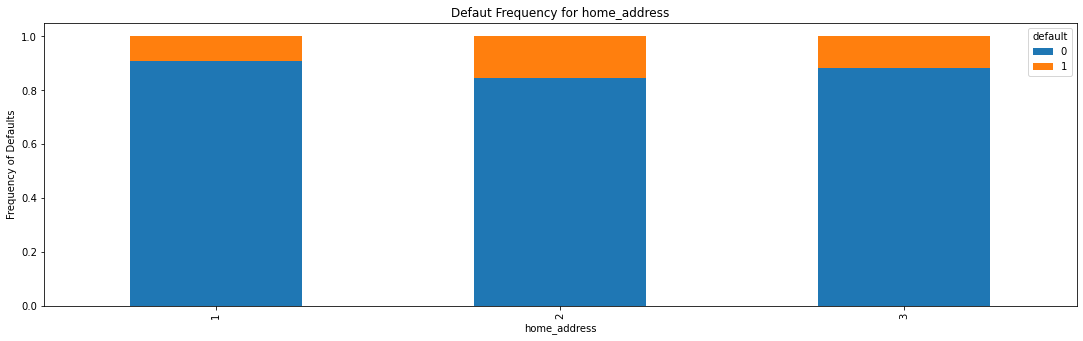

In [53]:
cross_table = pd.crosstab(pre_data.home_address, pre_data.default)
cross_table = cross_table.div(cross_table.sum(1).astype(float), axis=0)
cross_table.plot(
    kind='bar', stacked=True, figsize=(18.5, 5.2)
)
plt.title('Defaut Frequency for home_address')
plt.xlabel('home_address')
plt.ylabel('Frequency of Defaults')

#### 2.4.3 work_address - default

Text(0, 0.5, 'Frequency of Defaults')

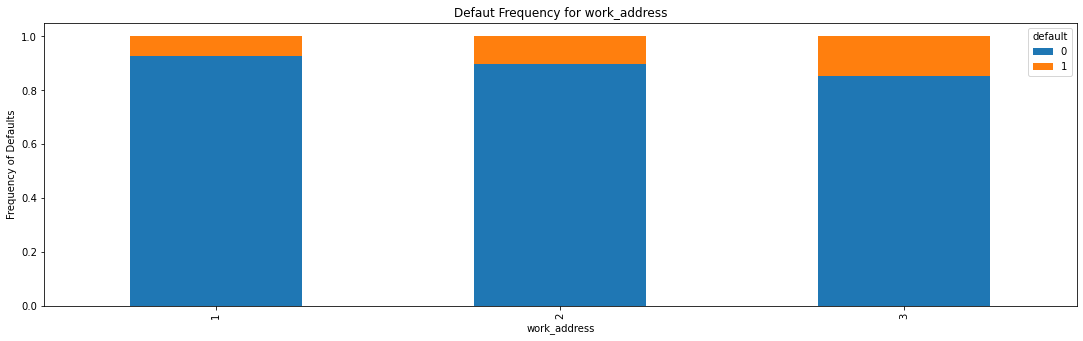

In [54]:
cross_table = pd.crosstab(pre_data.work_address, pre_data.default)
cross_table = cross_table.div(cross_table.sum(1).astype(float), axis=0)
cross_table.plot(
    kind='bar', stacked=True, figsize=(18.5, 5.2)
)
plt.title('Defaut Frequency for work_address')
plt.xlabel('work_address')
plt.ylabel('Frequency of Defaults')

#### 2.4.4 home_address - work_address

Text(0, 0.5, 'Frequency')

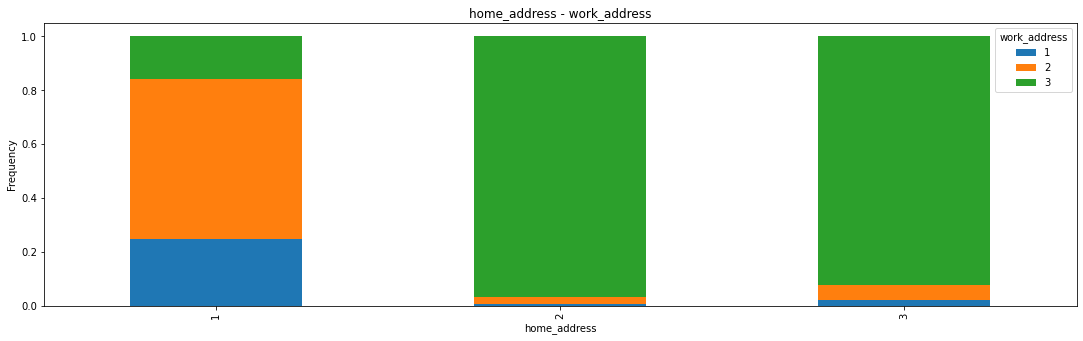

In [55]:
cross_table = pd.crosstab(pre_data.home_address, pre_data.work_address)
cross_table = cross_table.div(cross_table.sum(1).astype(float), axis=0)
cross_table.plot(
    kind='bar', stacked=True, figsize=(18.5, 5.2)
)
plt.title('home_address - work_address')
plt.xlabel('home_address')
plt.ylabel('Frequency')

Возможно, что стоит объединить категории `home_address = 2, 3` в одну категорию, большинство значений `work_address` для неё будет равно `3`.

### 2.5 Дальнейшая предобработка категориальных признаков

Создаём dummy признаки для колонок из списка `categorical_columns`.

In [56]:
pre_data_no_dummies = pre_data.copy()

pre_data = \
    feature_transformer.transform_features_categorical(pre_data, categorical_columns)
feature_transformer.mappings_categorical_features
pre_data.sample(3)

client_id  income  age  decline_app_cnt  bki_request_cnt  good_work  \
37788      35724   30000   50                0                0          1   
25008      91286   80000   46                0                4          1   
48016      81659   17000   44                0                1          0   

       car  car_type  foreign_passport  sex_male  default  education_ACD  \
37788    0         0                 0         0        0            0.0   
25008    0         0                 0         1        0            0.0   
48016    0         0                 0         1        0            0.0   

       education_GRD  education_NULL  education_PGR  education_SCH  \
37788            0.0             0.0            0.0            1.0   
25008            0.0             0.0            0.0            1.0   
48016            0.0             0.0            0.0            1.0   

       education_UGR  home_address_1  home_address_2  home_address_3  \
37788            0.0             1.0             0.0             0.0   
25008            0.0             0.0             1.0             0.0   
48016            0.0             0.0             1.0             0.0   

       work_address_1  work_address_2  work_address_3  
37788             0.0             1.0             0.0  
25008             0.0             0.0             1.0  
48016             0.0             0.0             1.0

In [57]:
categorical_columns_dummy = list(
    map(
        lambda kv: kv[1]["feature_names"],
        feature_transformer.mappings_categorical_features.items()
    )
)

categorical_columns_dummy = [
    feature_name \
        for feature_names in categorical_columns_dummy \
            for feature_name in feature_names
]
categorical_columns_dummy

['education_ACD',
 'education_GRD',
 'education_NULL',
 'education_PGR',
 'education_SCH',
 'education_UGR',
 'home_address_1',
 'home_address_2',
 'home_address_3',
 'work_address_1',
 'work_address_2',
 'work_address_3']

## 3. Базовый корреляционный анализ,<br />значимость переменных

### 3.1 Непрерывные переменные

#### 3.1.1 Корреляции

<AxesSubplot:>

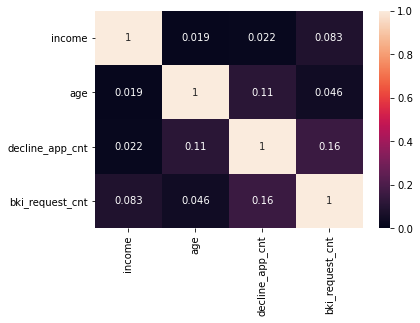

In [58]:
sns.heatmap(
    pre_data_no_dummies[numerical_columns].corr().abs(), annot=True, vmin=0, vmax=1
)

Видно, что количество отказов коррелирует с возрастом клиента(<0) и числом запросов в базу БКИ(>0), также корреляция сильнее отлична от нуля(<0) для связи числа отказов с доходом.)

#### 3.1.2 Значимость числовый переменных

<AxesSubplot:>

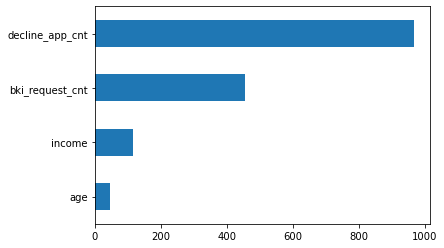

In [59]:
imp_num = pd.Series(
    f_classif(pre_data[numerical_columns], pre_data['default'])[0],
    index = numerical_columns
)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

Самый значимый признак из числовых - `decline_app_cnt`.<br />
Самый не значимый признак из числовых - `age`.

### 3.2 Бинарные переменные

#### 3.2.1 Корреляции

<AxesSubplot:>

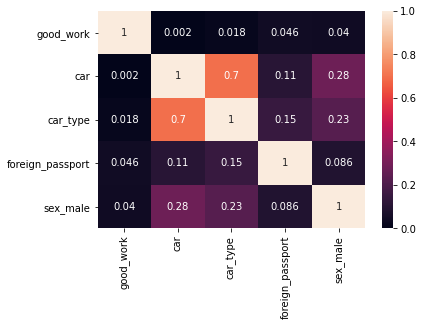

In [60]:
sns.heatmap(
    pre_data_no_dummies[binary_columns].corr().abs(), annot=True, vmin=0, vmax=1
)

### 3.3 Категориальные переменные

#### 3.3.1 Корреляции

<AxesSubplot:>

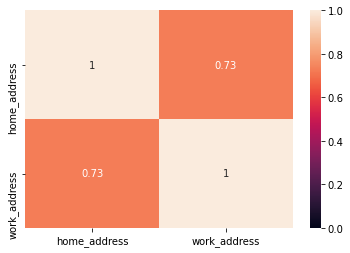

In [61]:
sns.heatmap(
    pre_data_no_dummies[categorical_columns].corr().abs(), annot=True, vmin=0, vmax=1
)

<AxesSubplot:>

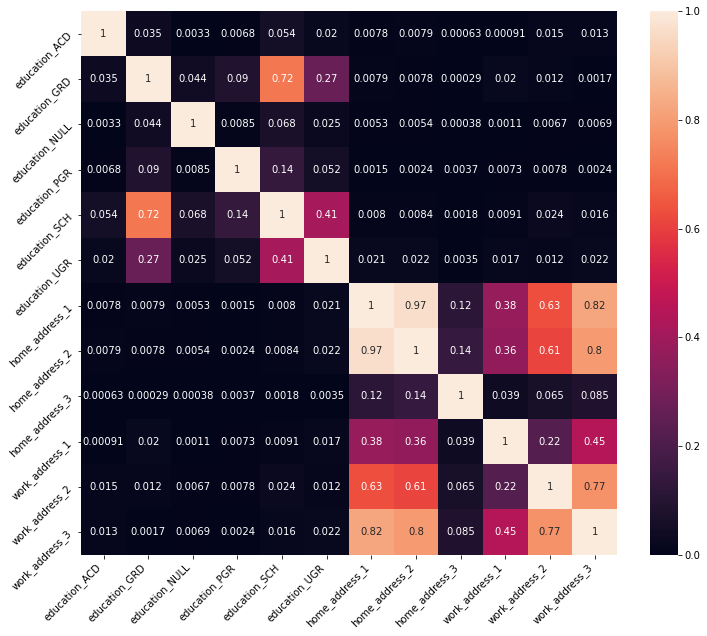

In [62]:
fig, ax = plt.subplots(figsize=(12, 10))
heatmap_figure = sns.heatmap(
    pre_data[categorical_columns_dummy].corr().abs(), annot=True, vmin=0, vmax=1, ax=ax
)
heatmap_figure.set_xticklabels(
    heatmap_figure.get_xticklabels(), rotation=45, horizontalalignment='right')
heatmap_figure.set_yticklabels(
    heatmap_figure.get_yticklabels(), rotation=45, horizontalalignment='right')
heatmap_figure

#### 3.4 Значимость всех категориальных переменных (бинарных)

#### 3.4.1 Без dummy признаков

In [63]:
pre_data_no_dummies_copy = pre_data_no_dummies.copy()
label_encoder_education = LabelEncoder()
pre_data_no_dummies_copy["education"] = \
    label_encoder_education.fit_transform(pre_data_no_dummies_copy["education"])
print(dict(enumerate(label_encoder_education.classes_)))

{0: 'ACD', 1: 'GRD', 2: 'NULL', 3: 'PGR', 4: 'SCH', 5: 'UGR'}


<AxesSubplot:>

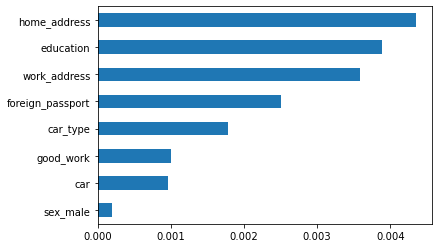

In [64]:
imp_cat = Series(
    mutual_info_classif(
            pre_data_no_dummies_copy[
                binary_columns + categorical_columns
            ],
            pre_data_no_dummies_copy['default'],
            discrete_features =True
        ),
    index = binary_columns + categorical_columns
)

imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')

Самый важный признак из категориальных - `home_address`.<br />
Наименее важный признак из категориальных - `sex_male`.

#### 3.4.2 С dummy признаками

<AxesSubplot:>

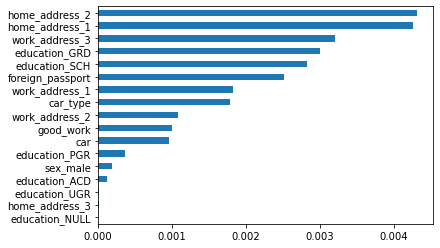

In [65]:
imp_cat = Series(
    mutual_info_classif(
            pre_data[
                binary_columns + categorical_columns_dummy
            ],
            pre_data['default'],
            discrete_features =True
        ),
    index = binary_columns + categorical_columns_dummy
)

imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')

Самые важные признаки из категориальных:
- `home_address_1`;
- `home_address_2`.

Наименее важные признак из категориальных:
- `sex_male`;
- `education_ACD`;
- `education_UGR`;
- `education_ACD`;
- `home_address_3`;
- `education_NULL`.

В основном вывод такой же как и без dummy признаков. Неважные признаки типа `education_NULL` на самом деле просто хуже представлены в выборке, но как видно из других диаграм могут влиять на вероятность дефолта, однако `sex_male` представлен в выборке сильно.

### 3.5 Общая матрица корреляций

<AxesSubplot:>

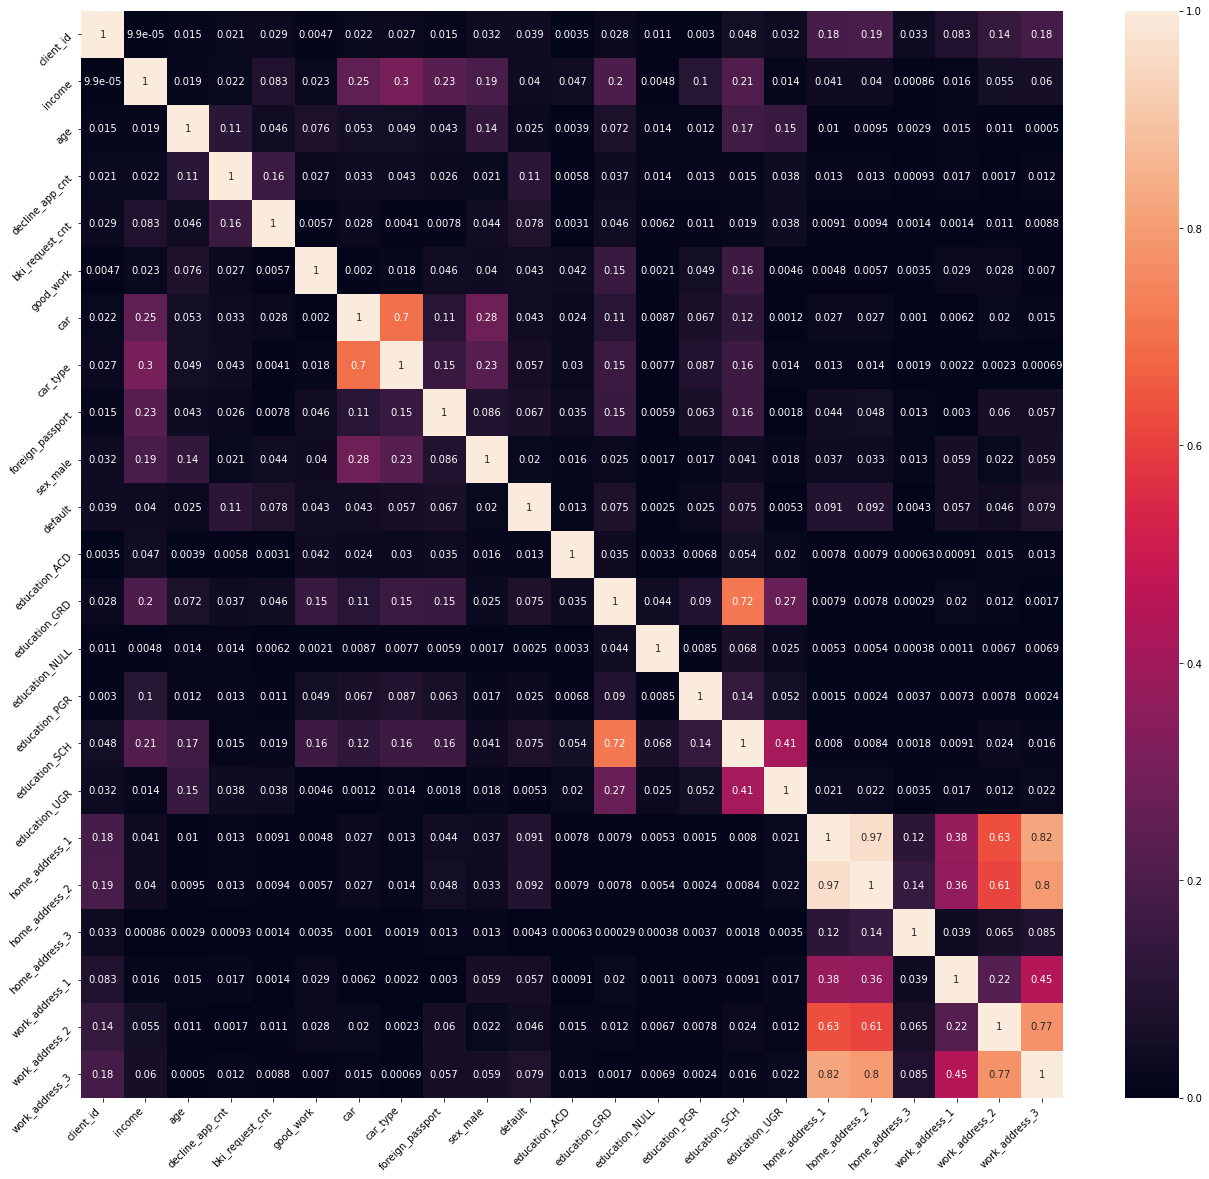

In [66]:
fig, ax = plt.subplots(figsize=(22, 20))
heatmap_figure = sns.heatmap(
    pre_data.corr().abs(), annot=True, vmin=0, vmax=1, ax=ax
)
heatmap_figure.set_xticklabels(
    heatmap_figure.get_xticklabels(), rotation=45, horizontalalignment='right')
heatmap_figure.set_yticklabels(
    heatmap_figure.get_yticklabels(), rotation=45, horizontalalignment='right')

heatmap_figure

## 4. Feature Engineering (создание новых признаков),<br />построение модели

In [67]:
numerical_columns = ["income", "age", "decline_app_cnt", "bki_request_cnt"]
binary_columns = ["good_work", "car", "car_type", "foreign_passport", "sex"]
categorical_columns = ["education", "home_address", "work_address"]

data_featured = pre_data.copy()

### 4.1 Feature Engineering

#### 4.1.1 Логарифмирование признаков `income` и `age`

In [68]:
data_featured["income"] = data_featured["income"].apply(lambda value: np.log(value))
data_featured["age"] = data_featured["age"].apply(lambda value: np.log(value))
data_featured.sample(3)

client_id     income       age  decline_app_cnt  bki_request_cnt  \
72359      40807   9.903488  3.178054                0                1   
44884      76832  11.289782  3.258097                0                3   
46097     105782   9.903488  3.637586                0                2   

       good_work  car  car_type  foreign_passport  sex_male  default  \
72359          0    0         0                 1         0        0   
44884          0    1         1                 0         0        0   
46097          0    0         0                 0         0        0   

       education_ACD  education_GRD  education_NULL  education_PGR  \
72359            0.0            1.0             0.0            0.0   
44884            0.0            1.0             0.0            0.0   
46097            0.0            0.0             0.0            0.0   

       education_SCH  education_UGR  home_address_1  home_address_2  \
72359            0.0            0.0             0.0             1.0   
44884            0.0            0.0             0.0             1.0   
46097            1.0            0.0             0.0             1.0   

       home_address_3  work_address_1  work_address_2  work_address_3  
72359             0.0             0.0             0.0             1.0  
44884             0.0             0.0             0.0             1.0  
46097             0.0             0.0             0.0             1.0

#### 4.1.2 Перемножение признаков `income` и `age`

In [69]:
from sklearn.preprocessing import PolynomialFeatures

pf = PolynomialFeatures(2)
age_income = pf.fit_transform(data_featured[["income", "age"]])
age_income_list = [features[4] for features in age_income]

if not "income_x_age" in data_featured.columns:
    data_featured.insert(data_featured.columns.get_loc("age") + 1, "income_x_age", np.nan)

data_featured["income_x_age"] = age_income_list
numerical_columns = numerical_columns + ["income_x_age"]
data_featured.sample(3)

client_id     income       age  income_x_age  decline_app_cnt  \
69316      62523  11.407565  3.555348     40.557864                1   
30529      69214   9.798127  3.526361     34.551728                0   
24886      59349   9.852194  3.496508     34.448272                1   

       bki_request_cnt  good_work  car  car_type  foreign_passport  sex_male  \
69316                4          0    1         0                 1         0   
30529                4          0    0         0                 0         0   
24886                5          0    1         1                 0         1   

       default  education_ACD  education_GRD  education_NULL  education_PGR  \
69316        0            0.0            0.0             0.0            0.0   
30529        0            0.0            1.0             0.0            0.0   
24886        0            0.0            0.0             0.0            0.0   

       education_SCH  education_UGR  home_address_1  home_address_2  \
69316            1.0            0.0             1.0             0.0   
30529            0.0            0.0             1.0             0.0   
24886            1.0            0.0             1.0             0.0   

       home_address_3  work_address_1  work_address_2  work_address_3  
69316             0.0             0.0             1.0             0.0  
30529             0.0             0.0             1.0             0.0  
24886             0.0             0.0             1.0             0.0

In [70]:
data_featured.describe()

client_id        income           age  income_x_age  \
count   73799.000000  73799.000000  73799.000000  73799.000000   
mean    55137.965094     10.345845      3.628019     37.516154   
std     31841.921168      0.697728      0.292819      3.768482   
min         1.000000      6.907755      3.044522     22.235206   
25%     27440.500000      9.903488      3.401197     34.827523   
50%     55274.000000     10.308953      3.610918     37.422987   
75%     82758.500000     10.778956      3.871201     40.021086   
max    110147.000000     13.815511      4.276666     57.671291   

       decline_app_cnt  bki_request_cnt     good_work           car  \
count     73799.000000     73799.000000  73799.000000  73799.000000   
mean          0.275749         2.000339      0.164894      0.324760   
std           0.804272         2.252073      0.371087      0.468288   
min           0.000000         0.000000      0.000000      0.000000   
25%           0.000000         0.000000      0.000000      0.000000   
50%           0.000000         1.000000      0.000000      0.000000   
75%           0.000000         3.000000      0.000000      1.000000   
max          33.000000        53.000000      1.000000      1.000000   

           car_type  foreign_passport      sex_male       default  \
count  73799.000000      73799.000000  73799.000000  73799.000000   
mean       0.189813          0.149948      0.436822      0.126994   
std        0.392156          0.357023      0.495996      0.332968   
min        0.000000          0.000000      0.000000      0.000000   
25%        0.000000          0.000000      0.000000      0.000000   
50%        0.000000          0.000000      0.000000      0.000000   
75%        0.000000          0.000000      1.000000      0.000000   
max        1.000000          1.000000      1.000000      1.000000   

       education_ACD  education_GRD  education_NULL  education_PGR  \
count   73799.000000   73799.000000    73799.000000   73799.000000   
mean        0.002629       0.316603        0.004160       0.017033   
std         0.051204       0.465154        0.064364       0.129394   
min         0.000000       0.000000        0.000000       0.000000   
25%         0.000000       0.000000        0.000000       0.000000   
50%         0.000000       0.000000        0.000000       0.000000   
75%         0.000000       1.000000        0.000000       0.000000   
max         1.000000       1.000000        1.000000       1.000000   

       education_SCH  education_UGR  home_address_1  home_address_2  \
count   73799.000000   73799.000000    73799.000000    73799.000000   
mean        0.526565       0.133010        0.441537        0.541417   
std         0.499297       0.339588        0.496574        0.498285   
min         0.000000       0.000000        0.000000        0.000000   
25%         0.000000       0.000000        0.000000        0.000000   
50%         1.000000       0.000000        0.000000        1.000000   
75%         1.000000       0.000000        1.000000        1.000000   
max         1.000000       1.000000        1.000000        1.000000   

       home_address_3  work_address_1  work_address_2  work_address_3  
count    73799.000000    73799.000000    73799.000000    73799.000000  
mean         0.017046        0.112928        0.277863        0.609209  
std          0.129445        0.316507        0.447948        0.487931  
min          0.000000        0.000000        0.000000        0.000000  
25%          0.000000        0.000000        0.000000        0.000000  
50%          0.000000        0.000000        0.000000        1.000000  
75%          0.000000        0.000000        1.000000        1.000000  
max          1.000000        1.000000        1.000000        1.000000

#### 4.1.2  Стандартизация числовых переменных

In [71]:
data_featured[numerical_columns].copy()

scaler = StandardScaler()
scaled_features = scaler.fit_transform(
    data_featured[numerical_columns].values
)
scaled_features_df = pd.DataFrame(
    scaled_features,
    index=data_featured.index,
    columns=numerical_columns
)
scaled_features_df.sample(3)

income       age  decline_app_cnt  bki_request_cnt  income_x_age
33194 -2.138641  1.535150        -0.342858         0.887926     -0.375486
66290 -0.314185  0.121381        -0.342858        -0.888227     -0.110554
15034  1.352881 -0.774619        -0.342858         0.443888      0.234213

In [72]:
data_featured[numerical_columns] = scaled_features_df[numerical_columns]
data_featured.sample(3)

client_id    income       age  income_x_age  decline_app_cnt  \
45555       8256 -1.366133  1.037530     -0.155460         3.387248   
15598       8099 -2.098265  1.648997     -0.266434        -0.342858   
47108      33486  0.359440 -0.248179      0.042078        -0.342858   

       bki_request_cnt  good_work  car  car_type  foreign_passport  sex_male  \
45555         0.443888          0    0         0                 0         1   
15598        -0.000150          0    0         0                 0         0   
47108        -0.000150          0    0         0                 0         0   

       default  education_ACD  education_GRD  education_NULL  education_PGR  \
45555        0            0.0            0.0             0.0            0.0   
15598        0            0.0            0.0             0.0            0.0   
47108        0            0.0            1.0             0.0            0.0   

       education_SCH  education_UGR  home_address_1  home_address_2  \
45555            1.0            0.0             1.0             0.0   
15598            1.0            0.0             0.0             1.0   
47108            0.0            0.0             1.0             0.0   

       home_address_3  work_address_1  work_address_2  work_address_3  
45555             0.0             0.0             1.0             0.0  
15598             0.0             0.0             0.0             1.0  
47108             0.0             1.0             0.0             0.0

### 4.2 Построение модели, итогового датасета

In [73]:
print(numerical_columns + binary_columns + categorical_columns_dummy)

['income', 'age', 'decline_app_cnt', 'bki_request_cnt', 'income_x_age', 'good_work', 'car', 'car_type', 'foreign_passport', 'sex', 'education_ACD', 'education_GRD', 'education_NULL', 'education_PGR', 'education_SCH', 'education_UGR', 'home_address_1', 'home_address_2', 'home_address_3', 'work_address_1', 'work_address_2', 'work_address_3']


In [74]:
feature_columns = numerical_columns + binary_columns + categorical_columns_dummy
feature_columns = ['income', 'age', 'decline_app_cnt', 'bki_request_cnt', 'good_work', 'car', 'car_type', 'foreign_passport', 'sex_male', 'education_ACD', 'education_PGR', 'education_GRD', 'education_SCH', 'home_address_1', 'home_address_2', 'home_address_3', 'work_address_1', 'work_address_2']
print(feature_columns)

['income', 'age', 'decline_app_cnt', 'bki_request_cnt', 'good_work', 'car', 'car_type', 'foreign_passport', 'sex_male', 'education_ACD', 'education_PGR', 'education_GRD', 'education_SCH', 'home_address_1', 'home_address_2', 'home_address_3', 'work_address_1', 'work_address_2']


In [75]:
X = data_featured[feature_columns]
Y = data_featured["default"]

X.sample(3)

income       age  decline_app_cnt  bki_request_cnt  good_work  car  \
8375   1.161500  1.356930        -0.342858         0.887926          0    1   
36482 -1.046317 -0.890396        -0.342858        -0.444189          0    0   
15206  0.679257 -0.554213        -0.342858         1.331965          0    1   

       car_type  foreign_passport  sex_male  education_ACD  education_PGR  \
8375          1                 1         1            0.0            0.0   
36482         0                 0         1            0.0            0.0   
15206         1                 1         1            0.0            0.0   

       education_GRD  education_SCH  home_address_1  home_address_2  \
8375             1.0            0.0             1.0             0.0   
36482            0.0            0.0             0.0             1.0   
15206            0.0            1.0             0.0             1.0   

       home_address_3  work_address_1  work_address_2  
8375              0.0             0.0             1.0  
36482             0.0             0.0             0.0  
15206             0.0             0.0             0.0

## 5. Обучение логистической регресии

### 5.1 Веса классов, посчитанные вручную

In [76]:
class_positive_weight = sample_size / (2 * class_positive)
class_negative_weight = sample_size / (2 * class_negative)

print(f"class_positive_weight = {class_positive_weight}")
print(f"class_negative_weight = {class_negative_weight}")

class_positive_weight = 3.937206572769953
class_negative_weight = 0.572733481304422


### 5.2 Обучение

In [77]:
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.2, random_state=42
)

Best C:  [0.1]
Best l1_ratio:  [None]
Logistic Regression ROC-AUC score: 0.673


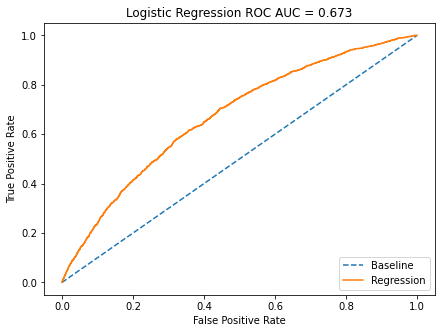

In [78]:
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.metrics import make_scorer, roc_auc_score, fbeta_score, f1_score, log_loss

cv = StratifiedKFold(n_splits=10, shuffle=True)

# auc = make_scorer(fbeta_score, beta=1)
auc = make_scorer(roc_auc_score, needs_proba=True)

model = LogisticRegressionCV(
    class_weight={0: class_negative_weight, 1: class_positive_weight},
    Cs=np.logspace(-3, -1, 3),
    penalty="l1",
    # l1_ratios=[0.05],
    # solver="saga",
    solver="liblinear",
    n_jobs=4,
    scoring=auc,
    tol=1e-6,
    max_iter=500)
model_fit_result = model.fit(X_train, Y_train)

Y_probs_predicted = model_fit_result.predict_proba(X_test)
Y_probs_predicted = Y_probs_predicted[:, 1]

print('Best C: ', model.C_)
print('Best l1_ratio: ', model.l1_ratio_)
# print('Iterations:\n', model.n_iter_)

fpr, tpr, threshold = roc_curve(Y_test, Y_probs_predicted)
roc_auc_score_value = roc_auc_score(Y_test, Y_probs_predicted)
print(f"Logistic Regression ROC-AUC score: {roc_auc_score_value:0.3f}")

plt.figure(figsize=(7, 5))
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc_score_value)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

In [79]:
model.coef_

array([[-0.10255892, -0.08908807,  0.2312487 ,  0.22301307, -0.24205624,
        -0.00731047, -0.288408  , -0.54160326,  0.22323997, -0.49853308,
        -0.49556649, -0.26496648,  0.17996365, -0.24885698,  0.21732244,
        -0.03415417, -0.291725  , -0.02545103]])

In [80]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold

# Regularisation types
penalty = ["l2"]

# Regularisation parameters
C = np.logspace(-2, 2, 5)

# Hyperparameters
hyperparameters = dict(
    C=C,
    penalty=penalty,
    solver=["newton-cg"]
)

model = LogisticRegression()
model_fit_result = model.fit(X_train, Y_train)

# Создаем сетку поиска с использованием 5-кратной перекрестной проверки
cv = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
clf = GridSearchCV(model, hyperparameters, cv=cv, verbose=0)

best_model = clf.fit(X_train, Y_train)

# View best hyperparameters
best_penalty = best_model.best_estimator_.get_params()['penalty']
best_C = best_model.best_estimator_.get_params()['C']
best_solver = best_model.best_estimator_.get_params()['solver']
print('Best Penalty: ', best_penalty)
print('Best C: ', best_C)
print('Best solver: ', best_solver)

Best Penalty:  l2
Best C:  0.01
Best solver:  newton-cg
